In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from torchtext.datasets import AG_NEWS

from tqdm import tqdm

from bert import EncodedDataset

/usr/venv/545bert/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
plt.style.use('ggplot')


In [52]:
device = torch.device("cpu")

batch_size = 16
num_epochs = 64
max_len = 64
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_iter = AG_NEWS(split='train')
trainset = to_map_style_dataset(train_iter)
#n_train = int(len(trainset) * vsplit)
#n_val = len(trainset) - n_train
#valset, trainset = random_split(trainset, [n_train, n_val])

#valset = EncodedDataset(valset, tokenizer, max_len, device)
trainset = EncodedDataset(trainset, tokenizer, max_len, device)

test_iter = AG_NEWS(split='test')
testset = to_map_style_dataset(test_iter)
testset = EncodedDataset(testset[:500], tokenizer, max_len, device)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"train set loaded - test: {len(testset)}")


/usr/venv/545bert/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(


train set loaded - test: 500


In [3]:
class Classifier_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.embedding = self.bert.embeddings
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 10) # 768 x 10
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 4)
        self.softmax = nn.Softmax(1)

    def forward(self, inbatch):
        output = self.bert(inbatch['ids'], attention_mask=inbatch['mask'], token_type_ids=inbatch['token_type_ids'])
        output = output.pooler_output
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)

        return output
    
    def forward2(self,data, attention_mask):
        output = self.bert.encoder(data, attention_mask=attention_mask)
        print(output.hidden_states[0])
        print(output.hidden_states[0].shape)
        output = self.bert.pooler(hidden_states=output.hidden_states[0])

        output = self.dropout(output)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output
    
    def forward_noemb(self, emb_data, mask):
        output = self.bert.forward(inputs_embeds=emb_data, attention_mask=mask)
        output = output.pooler_output
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        #output = self.softmax(output)
        return output

In [4]:
model = torch.load('saved_bert', map_location=torch.device('cpu'))
# for name, param in model.named_parameters():
#     param.requires_grad = True

In [5]:
def evaluate_topk(model, dataloader, topk=1):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, data in tqdm(enumerate(dataloader)):
            label = data['targets'] - torch.ones(data['targets'].shape, dtype=torch.long)
            emb_x = model.bert.embeddings.forward(data['ids'], token_type_ids=data['token_type_ids'])
            predicted_label = F.softmax(model.forward_noemb(emb_x, mask=data['mask']), dim=1)
            top_preds, top_idx = predicted_label.topk(k=topk, dim=1)
            for i, k in enumerate(top_idx):
                total_acc += int(label[i] in k)
            total_count += label.size(0)
    return total_acc/total_count

In [6]:
evaluate_topk(model, testloader, topk=1)

32it [00:27,  1.15it/s]


0.814

In [6]:
idx2label = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tec'}

In [11]:
def compute_text_saliency_map(X, mask, y, model):

    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)

    scores = F.softmax(model.forward_noemb(emb_data=X_var, mask=mask), dim=1)
    grad_scores = scores[0, y.item()]
    first_derivative = torch.autograd.grad(grad_scores, X_var)[0][0]

    
    #images_grads = X_var.grad.data[0]
    abs_text_grads = first_derivative.abs()
    saliency = abs_text_grads.norm(p=2, dim=1) # can be max, or mean, or norm with any p. euclidean norm for p =2
    saliency = (saliency-saliency.min())/(saliency.max()-saliency.min())

    return saliency


In [12]:
def show_text_saliency_maps(X, y, tokenizer, correct_label, label_dict, model):

    X_emb = model.bert.embeddings.forward(X['ids'], token_type_ids=X['token_type_ids'])

    predicted_class = F.softmax(model(X), dim=1).argmax()
    
    print(f'The predicted class is: {label_dict[predicted_class.item()]}, the correct class is: {correct_label}')
    y_tensor = torch.LongTensor(y)
    saliencies = np.zeros(shape = (X['ids'].shape[1], *y.size())) # TODO check if first dim should be X['ids'].shape[1]
    
    for i, label in enumerate(y):
        saliencies[:, i] = compute_text_saliency_map(X_emb, mask=X['mask'], y=label, model=model).numpy() 
        
    detoked = np.array(tokenizer.decode(X['ids'].flatten()).split())

    N = y.size()[0]
    pad_idx = np.min(np.where(detoked == '[SEP]')[0])
    x_ticks = np.arange(pad_idx+1)
    fig, axes = plt.subplots(N, 1, sharex=False, sharey=False, figsize=(8,60))
    for i, label in enumerate(y):
        axes[i].plot(saliencies[:pad_idx+1, i], x_ticks, '-o')
        # axes[i].set_xticklabels(np.linspace(start=0, stop=saliencies[:, i].max(), num=10))
        axes[i].set_yticks(ticks=x_ticks, labels=detoked[:pad_idx+1])
        axes[i].set_title(f'class \'{label_dict[label.item()]}\' prediction')
        axes[i].grid()
        axes[i].invert_yaxis()
    plt.show()

In [53]:
n = np.random.randint(low=0, high=len(testset))
n = 36374
test_point = trainset[n]

The predicted class is: Sports, the correct class is: Sports


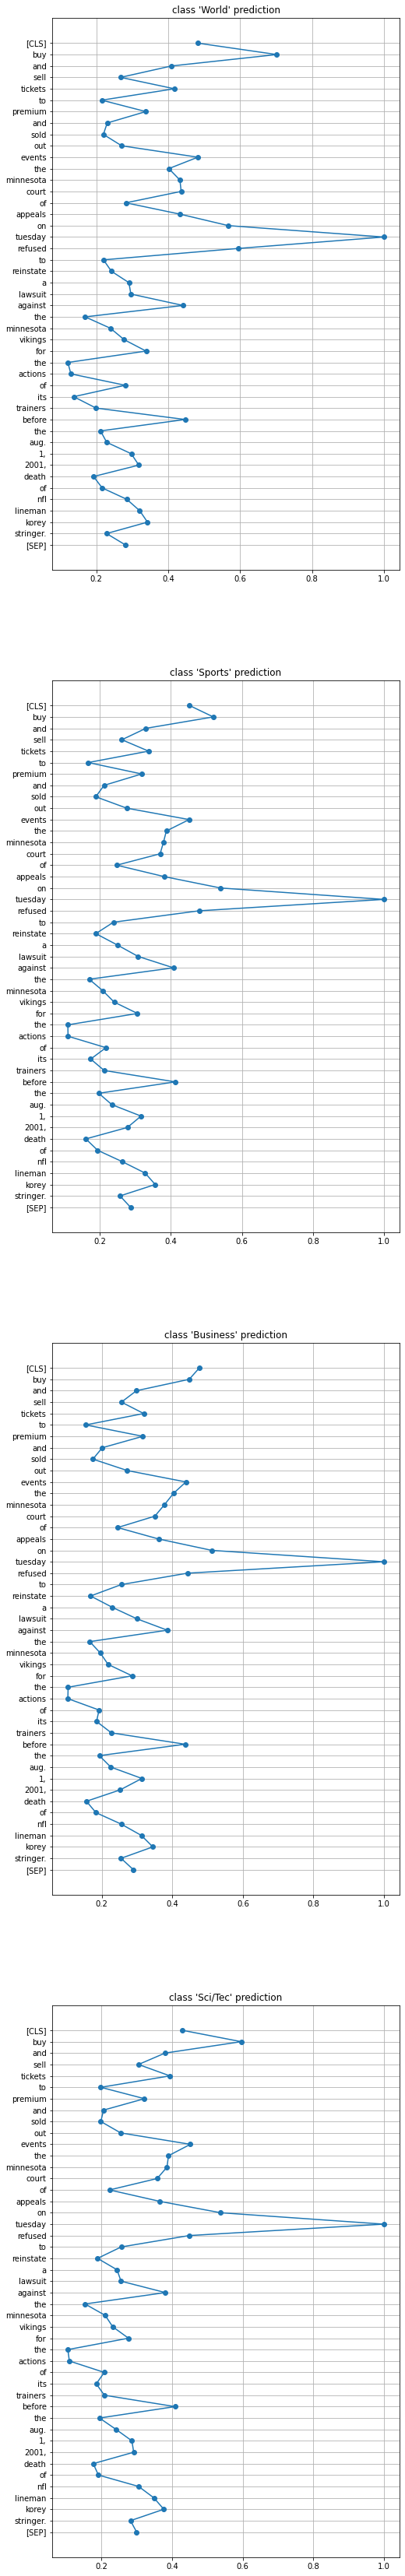

In [54]:
idx = test_point['targets'].item()-1
label = idx2label[idx]
for key in test_point:
    test_point[key] = torch.reshape(test_point[key], shape=(1,-1))

show_text_saliency_maps(test_point, torch.tensor([0, 1, 2, 3]), tokenizer, label, idx2label, model)

In [37]:
def compute_text_saliency_map_Hess(X, y, mask, model):

    #print(X.shape)
    
    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)

    scores = F.softmax(model.forward_noemb(emb_data=X_var, mask=mask), dim=1)
    grad_scores = scores[0, y.item()]
    first_derivative = torch.autograd.grad(grad_scores, X_var)[0][0]

    #get noisy results
    scale_fac=10**(-6)
    noise_tensor=scale_fac*torch.ones(X.shape[1], X.shape[2]) 
    X_noise=X+noise_tensor
    X_noise.unsqueeze(0)
    
    X_var_noise=Variable(X_noise, requires_grad=True)
    
    scores_noise = F.softmax(model.forward_noemb(emb_data=X_var_noise, mask=mask), dim=1)
    grad_scores_noise = scores_noise[0, y.item()]
    
    first_derivative_noise=torch.autograd.grad(grad_scores_noise, X_var_noise)[0][0]
    
    
    images_grads=(first_derivative_noise-first_derivative)/noise_tensor # Euler approximation of gradient
    
    abs_text_grads = images_grads.abs()
    saliency = abs_text_grads.norm(p=2, dim=1) # can be max, or mean, or norm with any p. euclidean norm for p =2

    return saliency

In [48]:
def show_text_saliency_maps_Hess(X, y, tokenizer, correct_label, label_dict, model):

    X_emb = model.bert.embeddings.forward(X['ids'], token_type_ids=X['token_type_ids'])
    
    predicted_class = F.softmax(model(X), dim=1)
    print(f'The predicted class is: {label_dict[predicted_class.argmax().item()]}, the correct class is: {correct_label}')
    y_tensor = torch.LongTensor(y)
    saliencies = np.zeros(shape = (X['ids'].shape[1], *y.size()))
    saliencies_backward_only = np.zeros(shape = (X['ids'].shape[1], *y.size()))
    saliencies_grad_only = np.zeros(shape = (X['ids'].shape[1], *y.size()))
    # saliencies_hess_only = np.zeros(shape = (X_emb.shape[0], *y.size()))
    
    for i, label in enumerate(y):
        saliencies_grad = compute_text_saliency_map(X_emb, mask=X['mask'], y=label, model=model).squeeze(0).numpy()
        saliencies_Hess = compute_text_saliency_map_Hess(X_emb, mask=X['mask'], y=label, model=model).squeeze(0).numpy()
        saliency_unnorm = saliencies_grad+0.5*saliencies_Hess
        saliencies_norm = (saliency_unnorm-saliency_unnorm.min())/(saliency_unnorm.max()-saliency_unnorm.min())
        saliencies_grad_norm=(saliencies_grad-saliencies_grad.min())/(saliencies_grad.max()-saliencies_grad.min())
        saliencies_hess_norm=(saliencies_Hess-saliencies_Hess.min())/(saliencies_Hess.max()-saliencies_Hess.min())
        print(saliencies_norm.shape)
        saliencies[:, i] = saliencies_norm
        saliencies_grad_only[:, i] = saliencies_grad_norm
        # saliencies_hess_only[:,i] = saliencies_hess_norm
        
    detoked = np.array(tokenizer.decode(X['ids'].flatten()).split())
    N = y.size()[0]
    pad_idx = np.min(np.where(detoked == '[SEP]')[0])
    x_ticks = np.arange(pad_idx+1)
    fig, axes = plt.subplots(1, N, sharex=False, sharey=False, figsize=(75, 30))
    for i, label in enumerate(y):
        axes[i].plot(saliencies[:pad_idx+1, i], x_ticks, '-o', label='Second Order')
        axes[i].plot(saliencies_grad_only[:pad_idx+1, i], x_ticks, linestyle='dashed', marker='*', label='First Order')
        # axes[i].plot(saliencies_hess_only[:pad_idx+1, i], x_ticks, '-*', label='Harmonic')

        axes[i].set_yticks(ticks=x_ticks)
        axes[i].set_yticklabels(labels=detoked[:pad_idx+1], fontsize=30)
        axes[i].tick_params(axis='x', labelsize=30)
        axes[i].set_title(f'class \'{label_dict[label.item()]}\' prediction: {predicted_class[0, i].item():.3f}', fontsize=30)
        axes[i].invert_yaxis()
        axes[i].legend()
    plt.show()
    fig.savefig('2ndsal')

{'input_ids': [101, 2572, 2094, 1998, 9980, 2031, 3668, 2037, 17368, 2974, 3820, 2083, 1996, 2203, 1997, 2263, 1012, 2761, 2772, 1999, 2285, 2526, 1010, 1996, 4707, 2001, 2761, 18517, 2000, 3612, 2039, 2012, 1996, 2203, 1997, 2384, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
The predicted class is: Sci/Tec, the correct class is: Sci/Tec
(64,)
(64,)
(64,)
(64,)


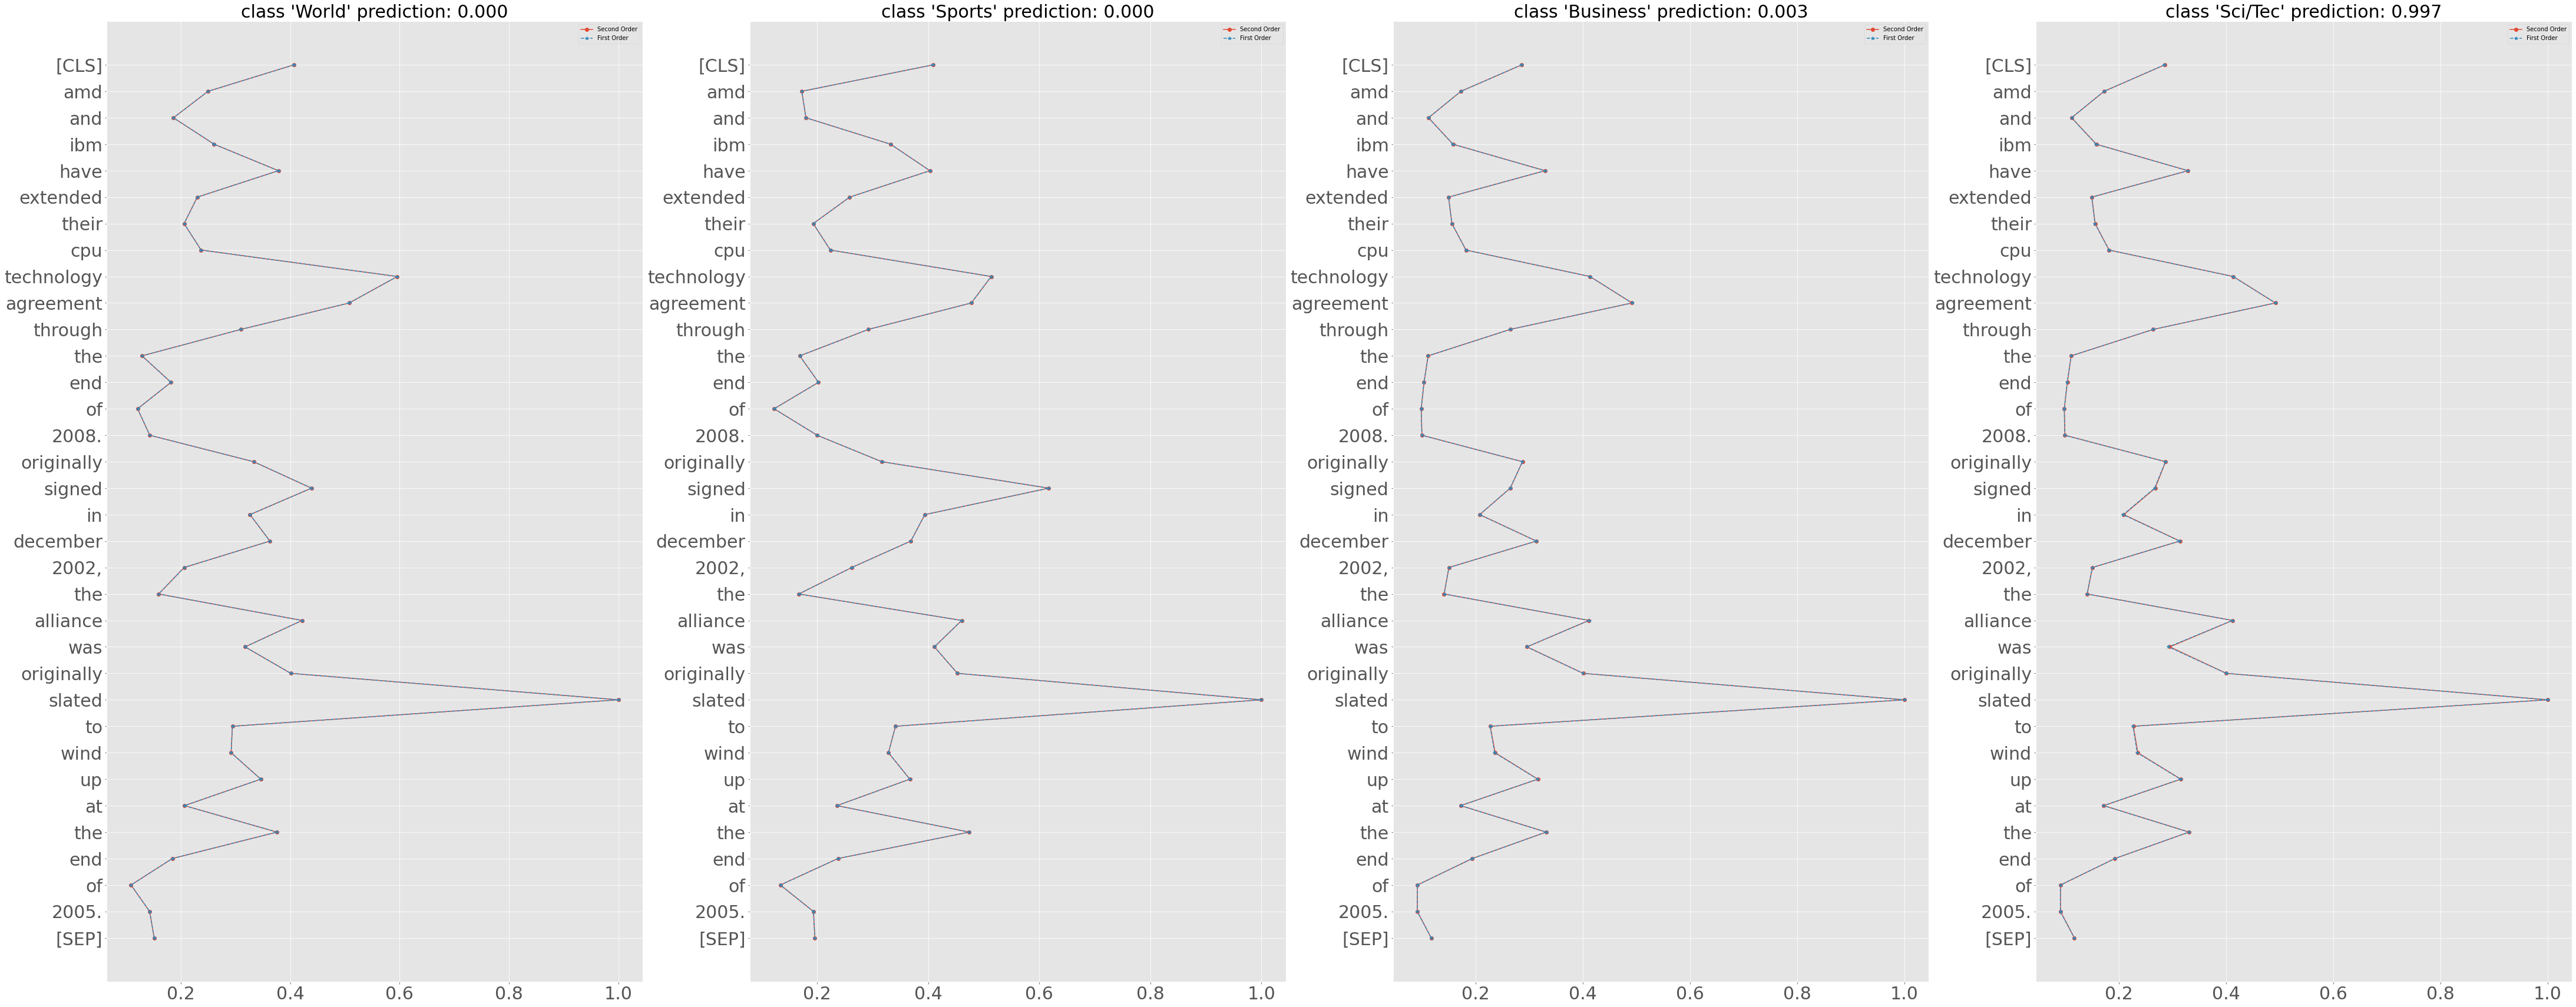

In [73]:
data_sample = 0
tp = get_toks("AMD and IBM have extended their CPU technology agreement through the end of 2008. Originally signed in December 2002, the alliance was originally slated to wind up at the end of 2005.", 3, tokenizer, device)
lab = idx2label[3]
show_text_saliency_maps_Hess(tp, torch.tensor([0, 1, 2, 3]), tokenizer, lab, idx2label, model)

#show_text_saliency_maps(test_point, torch.tensor([0, 1, 2, 3]), tokenizer, label, idx2label, model)

In [67]:
def get_toks(text, label, tokenizer, device):
    inputs = tokenizer(
        text,
        None,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]

    return {
        'ids': torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long).unsqueeze(0).to(device, dtype=torch.long),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0).to(device, dtype=torch.long),
        'targets': torch.tensor(label, dtype=torch.long).reshape(1,1).to(device, dtype=torch.long)
    }